In [5]:
import os, time
import getpass

import mlflow
from configs import DAGSHUB_USER_NAME, DAGSHUB_REPO_NAME, MODEL_DIR,  DEVICE
from utils import get_experiment_id, get_last_run_id

from fewshotdataloader import generate_loader, CARS

import torch
from utils import evaluate

import numpy as np
from utils import precision_recall_curve

import matplotlib.pyplot as plt
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
mlflow.set_tracking_uri(f'https://dagshub.com/{DAGSHUB_USER_NAME}/{DAGSHUB_REPO_NAME}.mlflow')

In [7]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'afhabibieee'
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass.getpass('enter pass: ')

In [19]:
def do_inference(
        run_id,
        n_way=5,
        n_shot=5,
        n_query=5,
        n_task=100,
):
        # dataset
        test_set = CARS(split='test', image_size=84)

        test_loader = generate_loader(
                'test',
                image_size=84,
                n_way=n_way,
                n_shot=n_shot,
                n_query=n_query,
                n_task=n_task,
                n_workers=2
        )

        # download model
        if not os.path.exists(os.path.join(MODEL_DIR, run_id)):
                local_path = mlflow.artifacts.download_artifacts(
                        run_id=run_id,
                        artifact_path='model',
                        dst_path=os.path.join(MODEL_DIR, run_id)
                )
        print("Artifacts downloaded in: {}".format(MODEL_DIR))

        # Load model
        logged_model = f'runs:/{run_id}/model'
        loaded_model = mlflow.pytorch.load_model(logged_model)
        print('Model name: {}, backbone name: {}\n'.format(
                loaded_model.__class__.__name__, loaded_model.backbone.__class__.__name__
        ))

        avg_accuracy, results, avg_time = evaluate(loaded_model, test_loader, test_set)

        result_path = f'../results/{run_id}.csv'
        with open(result_path, 'w') as file:
                for result in results:
                        file.write("%s\n" %result)
        
        thresholds = np.arange(start=0.4, stop=0.96, step=0.05)
        precisions, recalls, f1 = precision_recall_curve(result_path, thresholds)
        idx_f1_max = np.argmax(f1)        

        plt.style.use('Solarize_Light2')
        plt.plot(recalls[idx_f1_max], precisions[idx_f1_max], '-ro')
        plt.plot(recalls, precisions, linewidth=2, color="red")
        plt.xlabel("Recall", fontsize=12, fontweight='bold')
        plt.ylabel("Precision", fontsize=12, fontweight='bold')
        plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
        plt.show()
        
        print('The average accuracy and processing time with {} for {} tasks in data testing are {} and {} s\n'.format(
                DEVICE, n_task, avg_accuracy, avg_time
        ))
        print('Threshold confidence score is {} from best f1 {} (recalls: {}, precisions: {}).'.format(
                thresholds[idx_f1_max], f1[idx_f1_max], recalls[idx_f1_max], precisions[idx_f1_max]
        ))

Artifacts downloaded in: ../models/saved model


2022/12/01 21:18:23 WARNING mlflow.pytorch: Stored model version '1.12.1+cu102' does not match installed PyTorch version '1.13.0+cpu'


Model name: PrototypicalNetworks, backbone name: ResNet



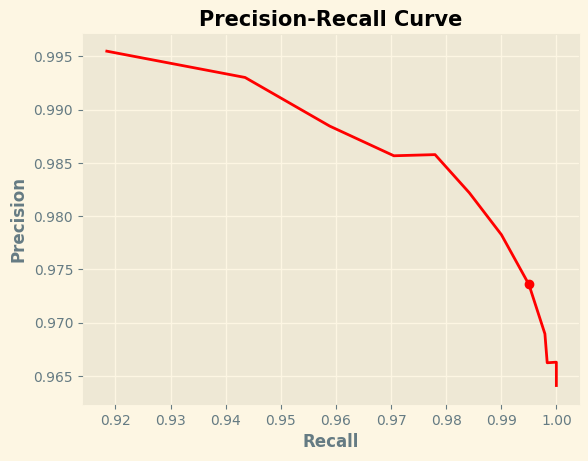

The average accuracy and processing time with cpu for 100 tasks in data testing are 0.9632 and 0.7364734315872192 s

Threshold confidence score is 0.6 from best f1 0.9841856644074759 (recalls: 0.9950166112956811, precisions: 0.9735879723689557).


In [21]:
# first model
run_id = 'c647a2612ffb4440930a5b17da7ab462'
do_inference(run_id)

Artifacts downloaded in: ../models/saved model


2022/12/01 20:49:49 WARNING mlflow.pytorch: Stored model version '1.12.1+cu102' does not match installed PyTorch version '1.13.0+cpu'


Model name: PrototypicalNetworks, backbone name: EfficientNet



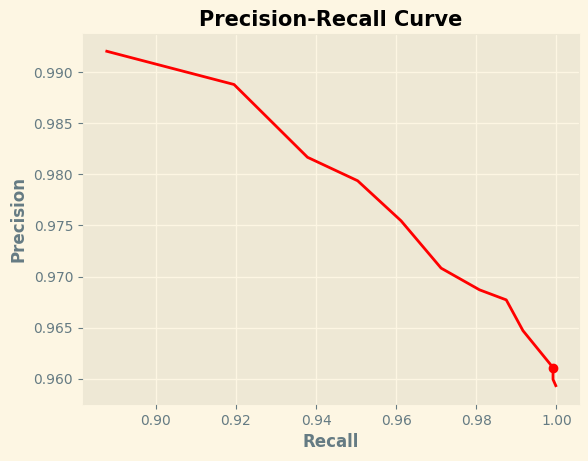

The average accuracy and processing time with cpu for 100 tasks in data testing are 0.9592 and 2.4962550806999206 s

Threshold confidence score is 0.5 from best f1 0.979758740543856 (recalls: 0.9991659716430359, precisions: 0.9610910549538708).


In [17]:
# second model
run_id = 'abbda0848d0e4aacb6bdcd1eeb0694d8'
do_inference(run_id)